## **RICE LEAF DISEASE DETECTION**

Rice is a major food crop, and diseases affecting rice leaves can significantly
reduce crop yield. Early and accurate detection of rice leaf diseases helps farmers
take timely action.

This project aims to classify rice leaf images into three disease categories:
- Leaf Smut
- Brown Spot
- Bacterial Leaf Blight

With the use of image processing and deep learning techniques to build and evaluate
classification models.

### Dataset :

- Total Images: 120
- Classes: 3
- Images per class: 40
- Image format: JPG

### **UNDERSTANDING THE DATASET**

In [1]:
import os

# Get the current working directory
 
print(os.getcwd()) 

/Users/brithiksha/Documents/Datamites Internship/rice_leaf_project


In [2]:
# List files and directories in the current working directory

print(os.listdir()) 

['.DS_Store', 'README.md', '.gitignore', 'rice_leaf_dataset', 'venv', '.git', 'rice_leaf.ipynb']


In [3]:
# Path to the dataset directory

dataset_path = 'rice_leaf_dataset/' 

# List all class directories in the dataset path

classes = os.listdir(dataset_path) 

# Print the class names found in the dataset

print("Classes found:", classes) 

Classes found: ['Bacterial leaf blight', 'Leaf smut', 'Brown spot']


In [5]:
valid_ext = ('.jpg', '.jpeg', '.png')

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    images = [
        f for f in os.listdir(class_path)
        if f.lower().endswith(valid_ext)
    ]
    print(f"Number of images in '{cls}': {len(images)}")
    

Number of images in 'Bacterial leaf blight': 40
Number of images in 'Leaf smut': 39
Number of images in 'Brown spot': 40


### Dataset Observations

- The dataset contains three rice leaf disease classes: Leaf Smut, Brown Spot, and Bacterial Leaf Blight.
- Brown Spot and Bacterial Leaf Blight each contain **40 images**.
- The Leaf Smut class contains **39 images**, indicating a minor class imbalance, the imbalance is minimal and is not expected to significantly impact model performance.
- Data augmentation techniques are applied during training to address potential imbalance effects.
- Overall, the dataset is suitable for training and evaluating image classification models.


### **DISPLAYING THE IMAGES**


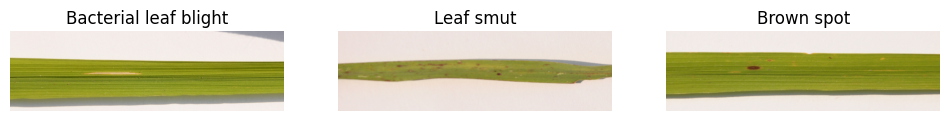

In [6]:
import matplotlib.pyplot as plt
from PIL import Image

plt.figure(figsize=(12, 4))

for i, cls in enumerate(classes):
    class_path = os.path.join(dataset_path, cls)
    
    # Pick first image from each class
    img_name = os.listdir(class_path)[0]
    img_path = os.path.join(class_path, img_name)
    
    img = Image.open(img_path)
    
    plt.subplot(1, 3, i + 1)
    plt.imshow(img)
    plt.title(cls)
    plt.axis('off')

plt.show()


In [7]:
from PIL import Image
import numpy as np

image_sizes = []

for cls in classes:
    class_path = os.path.join(dataset_path, cls)
    
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        img = Image.open(img_path)
        image_sizes.append(img.size)  # (width, height)

# Convert to numpy array
image_sizes = np.array(image_sizes)

# Print unique image sizes
unique_sizes = np.unique(image_sizes, axis=0)
print("Unique image sizes in dataset:")
print(unique_sizes)


Unique image sizes in dataset:
[[ 250  200]
 [ 286   92]
 [ 296   88]
 [ 301   71]
 [ 311  170]
 [ 316  127]
 [ 340   94]
 [ 359  168]
 [ 367   73]
 [ 376   80]
 [ 427  193]
 [ 456  124]
 [ 467  104]
 [ 503  174]
 [ 510  383]
 [ 537  216]
 [ 562  217]
 [ 565  233]
 [ 614  409]
 [ 617  244]
 [ 699  197]
 [ 741  291]
 [ 763  268]
 [ 765  224]
 [ 766  250]
 [ 768  514]
 [ 946  255]
 [ 948  211]
 [ 948  233]
 [1200  900]
 [1480  279]
 [1504  323]
 [1530  371]
 [3081  897]]


In [8]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 8


In [10]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Data augmentation for training data
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    rotation_range=25,
    width_shift_range=0.2,
    height_shift_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2
)
# Data generator for validation data
valid_datagen = ImageDataGenerator(
    rescale=1.0 / 255,
    validation_split=0.2            
)

In [11]:
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    subset='validation',
    shuffle=False
)


Found 96 images belonging to 3 classes.
Found 23 images belonging to 3 classes.


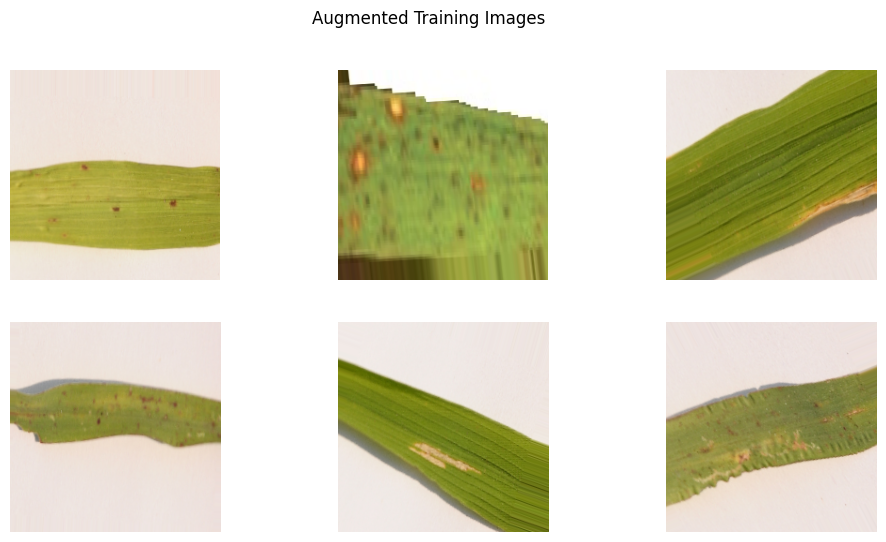

In [12]:
import matplotlib.pyplot as plt

# Get one batch of augmented images
images, labels = next(train_generator)

plt.figure(figsize=(12, 6))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i])
    plt.axis('off')

plt.suptitle("Augmented Training Images")
plt.show()


In [13]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam


In [14]:
# Load MobileNetV2 without top classifier
base_model = MobileNetV2(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Freeze base model weights
base_model.trainable = False


2026-01-15 17:42:49.902298: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M4
2026-01-15 17:42:49.902341: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2026-01-15 17:42:49.902350: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2026-01-15 17:42:49.902496: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2026-01-15 17:42:49.902511: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [15]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
output = Dense(3, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=output)


In [16]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)


In [17]:
model.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 112, 112,  │        864 │ input_layer[0][0] │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 112, 112,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 112, 112,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 112, 112,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 112, 112,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 112, 112,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 112, 112,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 112, 112,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 113, 113,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 56, 56,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 56, 56,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 56, 56,    │      2,304 │ block_1_depthwis

 Total params: 2,422,339 (9.24 MB)

 Trainable params: 164,355 (642.01 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [18]:
EPOCHS = 20

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS
)


Epoch 1/20


2026-01-15 17:43:40.911906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


12/12 ━━━━━━━━━━━━━━━━━━━━ 7s 216ms/step - accuracy: 0.3438 - loss: 1.6595 - val_accuracy: 0.3478 - val_loss: 1.3718
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 79ms/step - accuracy: 0.3750 - loss: 1.3986 - val_accuracy: 0.4783 - val_loss: 1.2183
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5104 - loss: 1.0548 - val_accuracy: 0.5217 - val_loss: 0.8493
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5104 - loss: 1.1847 - val_accuracy: 0.7391 - val_loss: 0.7949
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.5417 - loss: 1.0881 - val_accuracy: 0.7391 - val_loss: 0.7078
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6042 - loss: 0.9549 - val_accuracy: 0.7391 - val_loss: 0.6654
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.6562 - loss: 0.7661 - val_accuracy: 0.7391 - val_loss: 0.6082
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 78ms/step - accuracy: 0.7292 - loss: 0.6797 - val_accuracy: 0.7826 - val_loss: 0